# Tahu lah apa ini?

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/01.Dataset-Rofiqul/Ujicoba3-29052024

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [3]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
file_path = 'dataset/agriculture_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
# data.head(),data.info(),data.describe()

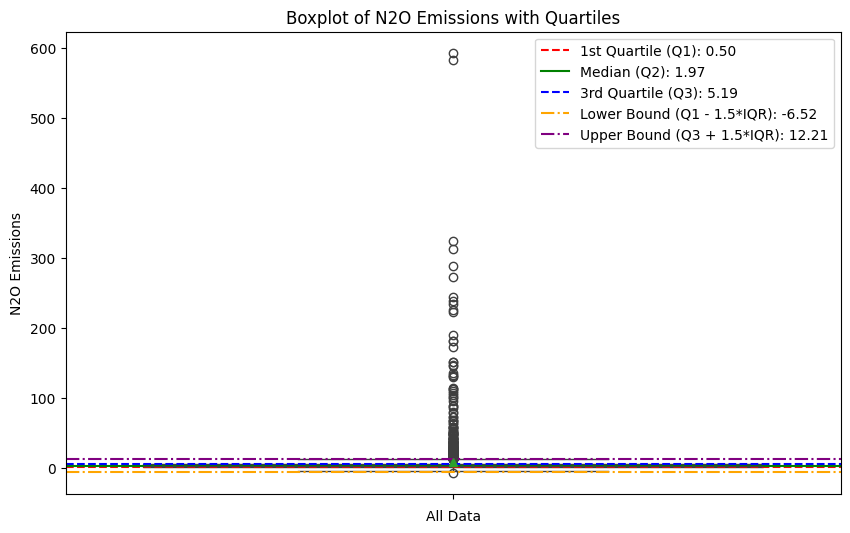

In [4]:


# Assuming your data is already loaded into a DataFrame called 'data'

# Generate a box plot for N2O with quartile divisions
plt.figure(figsize=(10, 6))

# Boxplot for N2O with quartiles
sns.boxplot(y='N2O', data=data, showmeans=True)
plt.title('Boxplot of N2O Emissions with Quartiles')
plt.ylabel('N2O Emissions')
plt.xlabel('All Data')

# Calculate quartiles and IQR
q1 = data['N2O'].quantile(0.25)
q2 = data['N2O'].median()
q3 = data['N2O'].quantile(0.75)
iqr = q3 - q1

# Adding horizontal lines for quartiles and IQR
plt.axhline(q1, color='r', linestyle='--', label=f'1st Quartile (Q1): {q1:.2f}')
plt.axhline(q2, color='g', linestyle='-', label=f'Median (Q2): {q2:.2f}')
plt.axhline(q3, color='b', linestyle='--', label=f'3rd Quartile (Q3): {q3:.2f}')
plt.axhline(q1 - 1.5 * iqr, color='orange', linestyle='-.', label=f'Lower Bound (Q1 - 1.5*IQR): {q1 - 1.5 * iqr:.2f}')
plt.axhline(q3 + 1.5 * iqr, color='purple', linestyle='-.', label=f'Upper Bound (Q3 + 1.5*IQR): {q3 + 1.5 * iqr:.2f}')

plt.legend()
plt.show()

Number of outliers per column:
N2O         32
N_rate       0
PP2         47
PP7         38
AirT         3
WFPS25cm     0
NH4         23
NO3         64
Clay         0
Sand         0
SOM          0
dtype: int64


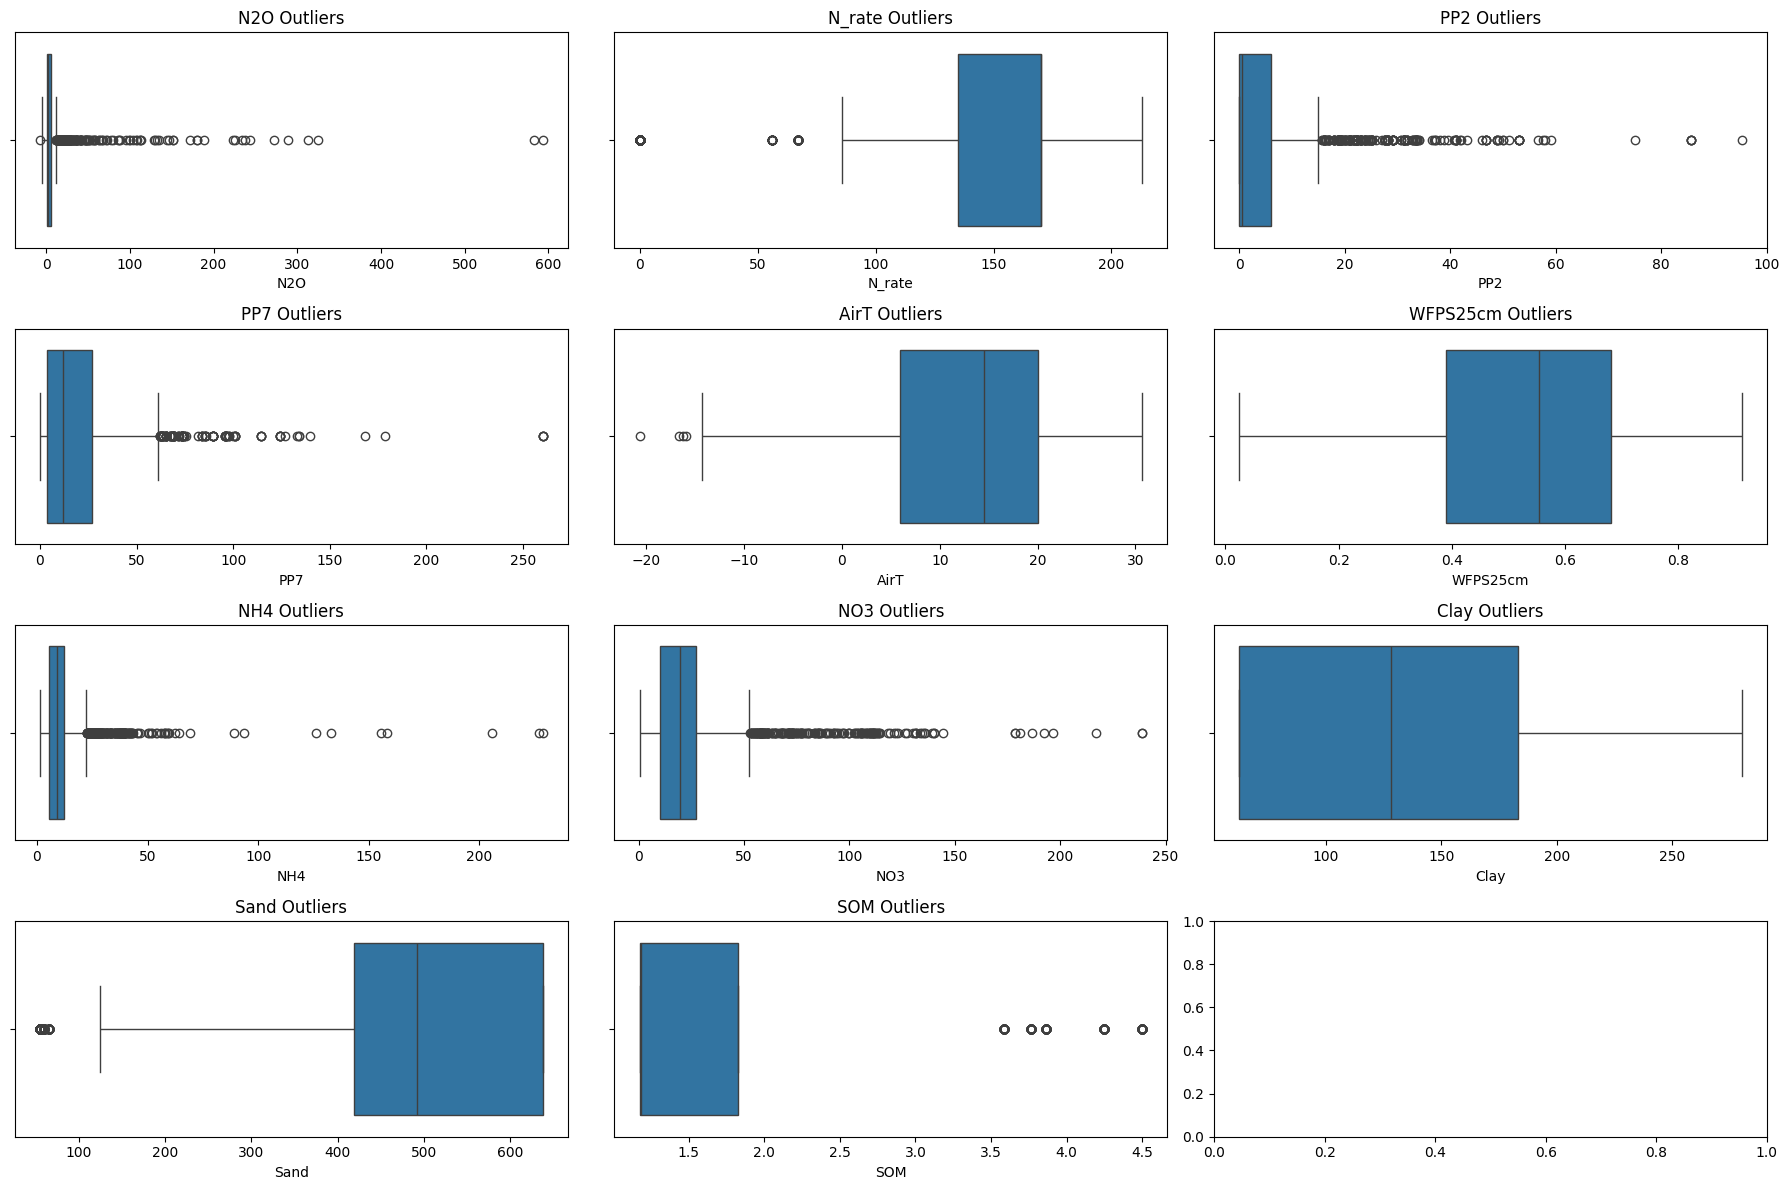

Number of multivariate outliers: 0


In [5]:
df=data
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# 1. Identify outliers using the Z-score method
z_scores = {}
for col in numerical_cols:
    z = np.abs((df[col] - df[col].mean()) / df[col].std())
    z_scores[col] = z

# Define the threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Create a boolean mask to identify outliers
outlier_mask = pd.DataFrame({col: z_scores[col] > threshold for col in numerical_cols})

# Print the number of outliers for each column
print("Number of outliers per column:")
print(outlier_mask.sum())

# 2. Visualize the outliers using boxplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Outliers")

plt.tight_layout()
plt.show()

# 3. Identify potential multivariate outliers using Mahalanobis distance
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

X = df[numerical_cols].values
cov_mat = np.cov(X.T)
inv_cov_mat = np.linalg.inv(cov_mat)

# Calculate the Mahalanobis distance for each data point
mahal_dists = [mahalanobis(x, X.mean(axis=0), inv_cov_mat) for x in X]

# Determine the outlier threshold based on the chi-square distribution
p = len(numerical_cols)
threshold = chi2.isf(0.01, df=p)

# Create a boolean mask to identify multivariate outliers
multivariate_outlier_mask = np.array(mahal_dists) > threshold

# Print the number of multivariate outliers
print(f"Number of multivariate outliers: {sum(multivariate_outlier_mask)}")

Number of outliers per column:
N2O         251
N_rate      283
PP2         244
PP7         114
AirT          4
WFPS25cm      0
NH4         193
NO3         197
Clay          0
Sand        385
SOM         482
dtype: int64


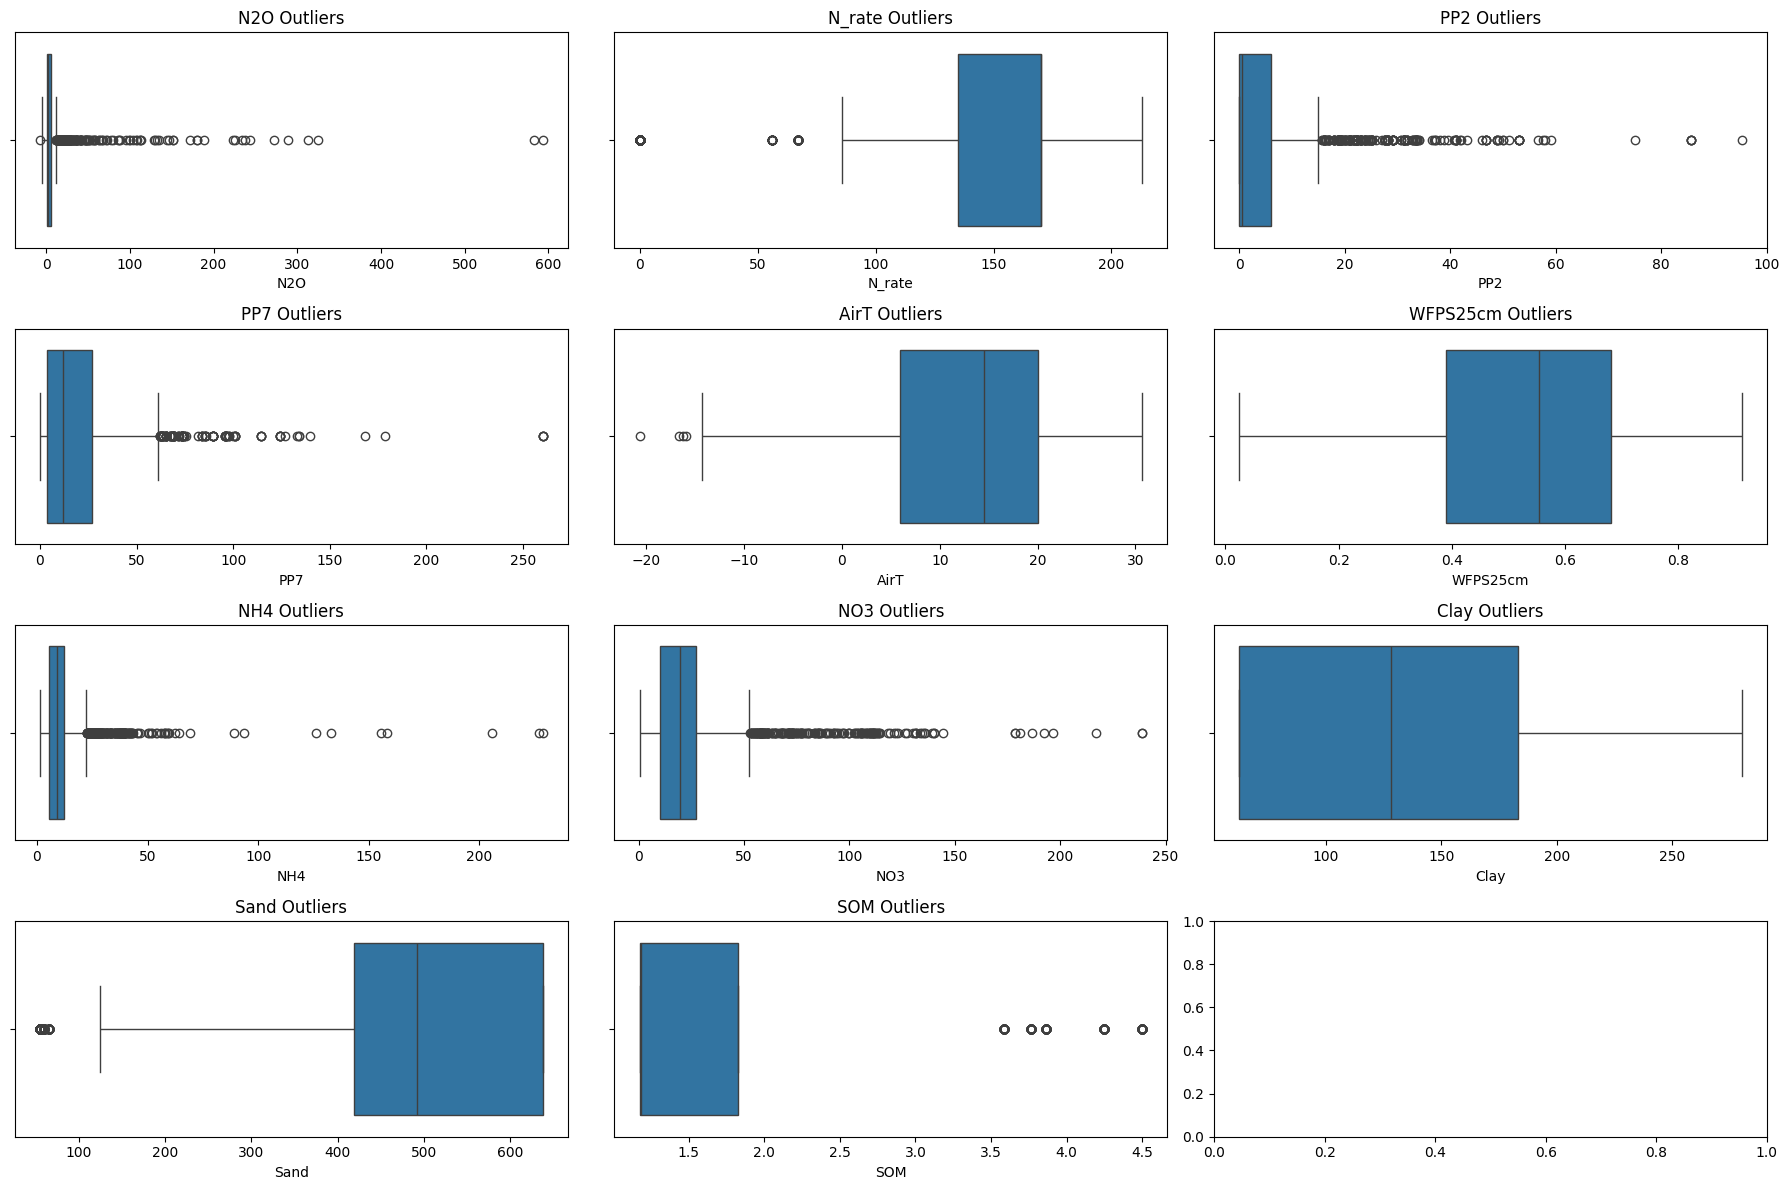

In [6]:
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# Detect outliers using the IQR method
outlier_mask = pd.DataFrame()
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask[col] = outliers

# Print the number of outliers for each column
print("Number of outliers per column:")
print(outlier_mask.sum())

# Visualize the outliers using boxplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Outliers")

plt.tight_layout()
plt.show()

## Malahobis Distance Outliers Detection

Number of outliers: 6


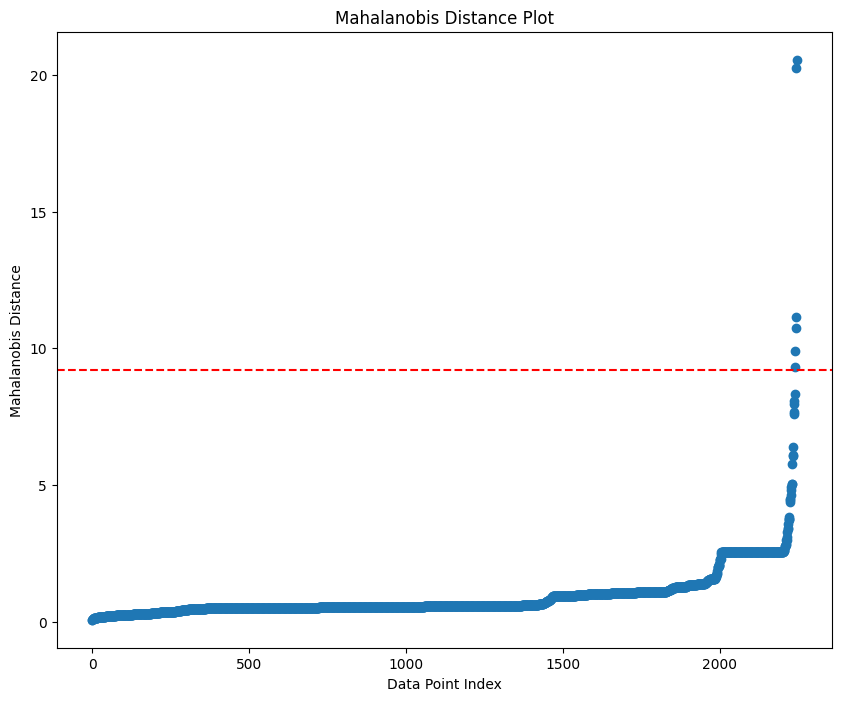

In [7]:
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate'] #, 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']
# numerical_cols = ['N2O']

# Detect outliers using the Mahalanobis distance
X = df[numerical_cols].values
cov_mat = np.cov(X.T)
inv_cov_mat = np.linalg.inv(cov_mat)

# Calculate the Mahalanobis distance for each data point
mahal_dists = [mahalanobis(x, X.mean(axis=0), inv_cov_mat) for x in X]

# Determine the outlier threshold based on the chi-square distribution
p = len(numerical_cols)
threshold = chi2.isf(0.01, df=p)

# Create a boolean mask to identify outliers
outlier_mask = np.array(mahal_dists) > threshold

# Print the number of outliers
print(f"Number of outliers: {sum(outlier_mask)}")

# Visualize the outliers using a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(range(len(mahal_dists)), sorted(mahal_dists))
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Mahalanobis Distance Plot')
plt.xlabel('Data Point Index')
plt.ylabel('Mahalanobis Distance')
plt.show()

## Isolation Forest

Number of outliers: 23


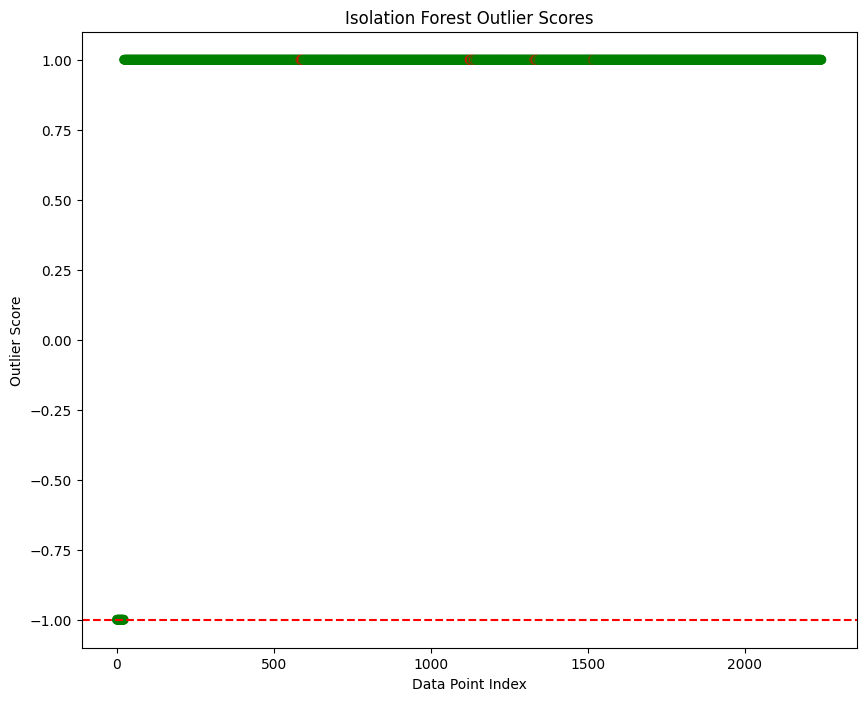

In [8]:
df=data
# Define the numerical columns
numerical_cols = ['N2O'] # 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# Handle missing values using the mean imputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df[numerical_cols])

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_scores = iso_forest.fit_predict(X)

# Create a boolean mask to identify outliers
outlier_mask = outlier_scores == -1

# Print the number of outliers
print(f"Number of outliers: {sum(outlier_mask)}")

# Visualize the outliers using a scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(range(len(outlier_scores)), sorted(outlier_scores), c=['g' if score == 1 else 'r' for score in outlier_scores])
plt.axhline(y=-1, color='r', linestyle='--')
plt.title('Isolation Forest Outlier Scores')
plt.xlabel('Data Point Index')
plt.ylabel('Outlier Score')
plt.show()

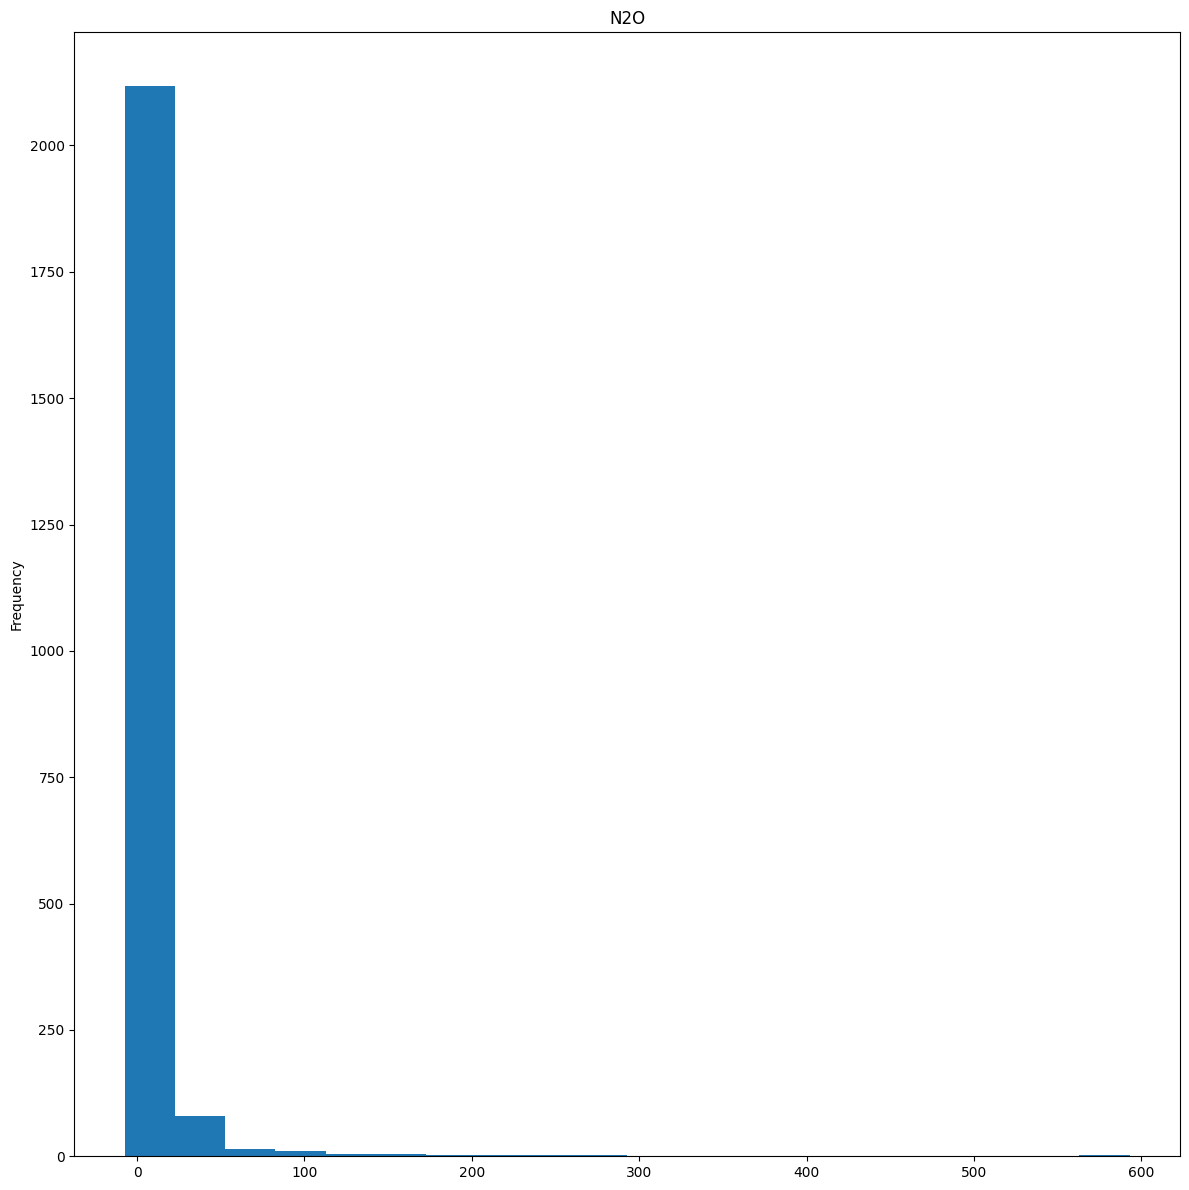

In [9]:
# Create a boolean mask to identify outliers
outlier_mask = outlier_scores == -1

# Visualize the outliers using a scatter plot matrix
plt.figure(figsize=(12, 12))
num_cols = len(numerical_cols)
for i in range(num_cols):
    for j in range(num_cols):
        if i == j:
            # Plot the histogram for the diagonal subplots
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            df[numerical_cols[i]].plot(kind='hist', bins=20, title=numerical_cols[i])
        else:
            # Plot the scatter plot for the off-diagonal subplots
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            plt.scatter(df[numerical_cols[j]], df[numerical_cols[i]], c=['g' if outlier_scores[k] == 1 else 'r' for k in range(len(outlier_scores))], s=10, alpha=0.5)
            plt.xlabel(numerical_cols[j])
            plt.ylabel(numerical_cols[i])

plt.tight_layout()
plt.show()


In [10]:
# Visualize the outliers using a scatter plot
plt.figure(figsize=(3, 2))
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        plt.subplot(3, 4, i * (len(numerical_cols)-1) + j - i + 1)
        plt.scatter(df[numerical_cols[j]], df[numerical_cols[i]], c=['g' if score == 1 else 'r' for score in outlier_scores], s=10, alpha=0.5)
        plt.xlabel(numerical_cols[j])
        plt.ylabel(numerical_cols[i])
        plt.title(f"{numerical_cols[i]} vs {numerical_cols[j]}")

plt.tight_layout()
plt.show()

<Figure size 300x200 with 0 Axes>

## Z-score

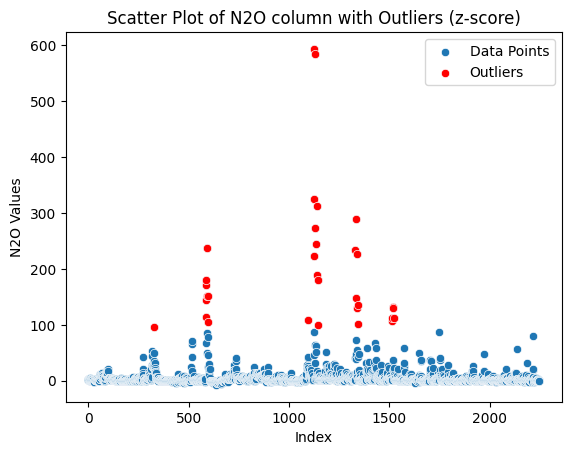

In [11]:
# Assuming you have a DataFrame called df containing the tabular data
n2o_column = df['N2O']

# Calculate the z-scores
z_scores = (n2o_column - n2o_column.mean()) / n2o_column.std()

# Define the z-score threshold for outliers
threshold_z_score = 3

# Detect outliers
outliers_z_score = n2o_column[abs(z_scores) > threshold_z_score]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_z_score.index, y=outliers_z_score, color='red', label='Outliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (z-score)')

# Show the plot
plt.legend()
plt.show()

## Tuckey Fences

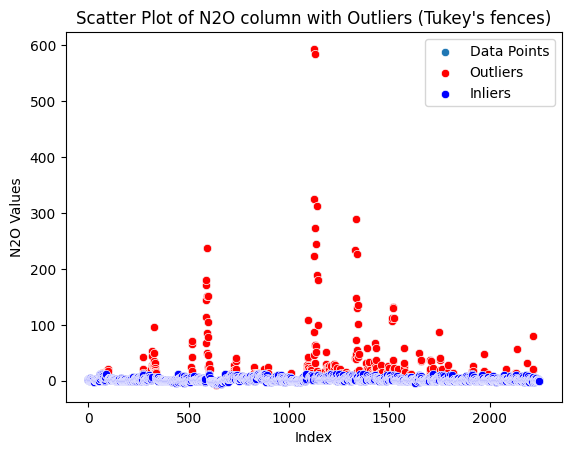

In [12]:
# Assuming you have a DataFrame called df containing the tabular data
n2o_column = df['N2O']

# Calculate the IQR
Q1 = n2o_column.quantile(0.25)
Q3 = n2o_column.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Detect outliers
outliers_tukey = n2o_column[(n2o_column < lower_fence) | (n2o_column > upper_fence)]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_tukey.index, y=outliers_tukey, color='red', label='Outliers')

# Highlight the data points within the fences using blue color
inliers_tukey = n2o_column[(n2o_column >= lower_fence) & (n2o_column <= upper_fence)]
sns.scatterplot(x=inliers_tukey.index, y=inliers_tukey, color='blue', label='Inliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (Tukey\'s fences)')

# Show the plot
plt.legend()
plt.show()

## LOF

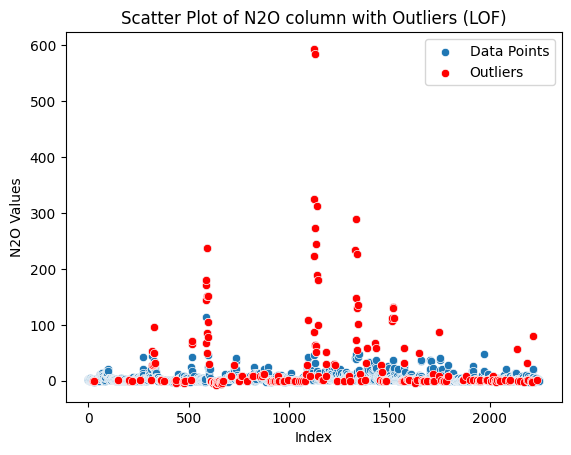

In [13]:
from sklearn.neighbors import LocalOutlierFactor

# Assuming you have a DataFrame called df containing the tabular data
# n2o_column = df['N2O']

# Reshape the data into a 2D array for LOF input
X = np.array(n2o_column).reshape(-1, 1)

# Create an instance of the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed

# Fit the LOF model and calculate LOF scores
lof_scores = lof.fit_predict(X)

# Identify outliers based on negative LOF scores
outliers_lof = n2o_column[lof_scores == -1]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_lof.index, y=outliers_lof, color='red', label='Outliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (LOF)')

# Show the plot
plt.legend()
plt.show()

In [14]:
# !pip install pyod

In [15]:
from scipy.stats import iqr
from scipy.spatial.distance import mahalanobis
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN, OPTICS


In [16]:
df

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,0.00,-2.00,276,241,0.666508,11.046340,22.940812,62.500000,637.500000,1.174072
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,0.00,-2.40,277,242,0.640608,11.008087,22.959578,62.500000,637.500000,1.174072
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,8.64,0.30,285,250,0.728085,10.831669,23.221928,62.500000,637.500000,1.174072
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,8.13,-3.80,286,251,0.686872,10.849792,23.271978,62.500000,637.500000,1.174072
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,8.39,17.60,312,277,0.716221,10.204748,24.206855,62.500000,637.500000,1.174072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,8.13,10.81,167,167,0.390203,17.061793,5.803681,128.333333,491.666667,1.806000
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,8.13,5.64,197,197,0.317040,5.624730,5.429873,162.500000,490.375000,1.496400
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,8.13,5.64,197,197,0.341428,3.504328,7.239000,183.250000,432.875000,1.186800
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,8.13,5.64,197,197,0.365815,3.636931,8.434294,169.833333,418.833333,1.823200


c:\laragon\bin\python\python-3.10\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


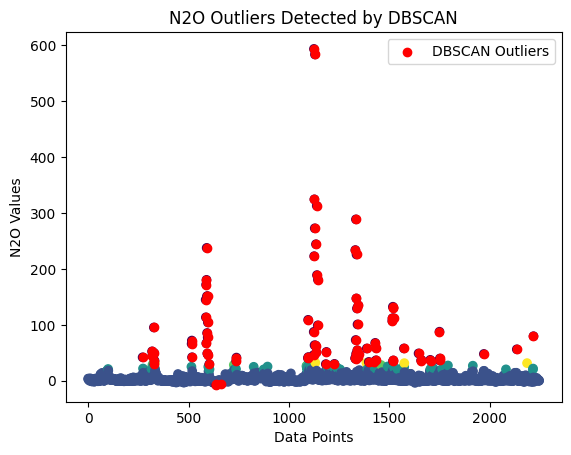

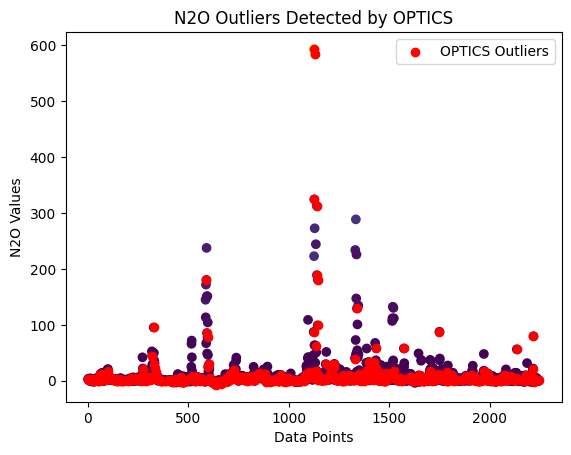

DBSCAN Outlier Table:
      Data Point  N2O Value  DBSCAN Cluster Label
271          271  41.942813                    -1
318          318  52.563836                    -1
319          319  44.874451                    -1
327          327  95.263745                    -1
328          328  49.745098                    -1
...          ...        ...                   ...
1750        1750  36.480000                    -1
1751        1751  39.810000                    -1
1970        1970  47.920000                    -1
2134        2134  56.240000                    -1
2217        2217  79.680000                    -1

[89 rows x 3 columns]

OPTICS Outlier Table:
   Data Point  N2O Value  OPTICS Reachability Distance
0           0   3.896742                           inf


In [17]:
# Extract the N2O column
n2o_values = df['N2O']

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from DBSCAN
dbscan_outliers = np.where(dbscan.labels_ == -1)[0]

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics.fit(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from OPTICS
optics_outliers = np.where(optics.labels_ == -1)[0]

# Create pandas DataFrame tables for DBSCAN and OPTICS outlier results
dbscan_table = pd.DataFrame({'Data Point': df.index,
                             'N2O Value': n2o_values,
                             'DBSCAN Cluster Label': dbscan.labels_})
optics_table = pd.DataFrame({'Data Point': df.index,
                             'N2O Value': n2o_values,
                             'OPTICS Reachability Distance': optics.reachability_})

# Visualize DBSCAN outlier detection
plt.scatter(dbscan_table['Data Point'], dbscan_table['N2O Value'], c=dbscan_table['DBSCAN Cluster Label'], cmap='viridis')
plt.scatter(dbscan_outliers, dbscan_table.loc[dbscan_outliers, 'N2O Value'], c='red', label='DBSCAN Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by DBSCAN')
plt.legend()
plt.show()

# Visualize OPTICS outlier detection
plt.scatter(optics_table['Data Point'], optics_table['N2O Value'], c=optics_table['OPTICS Reachability Distance'], cmap='viridis')
plt.scatter(optics_outliers, optics_table.loc[optics_outliers, 'N2O Value'], c='red', label='OPTICS Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by OPTICS')
plt.legend()
plt.show()

# Print the DBSCAN outlier table
print("DBSCAN Outlier Table:")
print(dbscan_table[dbscan_table['DBSCAN Cluster Label'] == -1])

# Print the OPTICS outlier table
print("\nOPTICS Outlier Table:")
print(optics_table[optics_table['OPTICS Reachability Distance'] == np.inf])

In [18]:
dbscan_table.head(), optics_table.head()

(   Data Point  N2O Value  DBSCAN Cluster Label
 0           0   3.896742                     0
 1           1   2.190218                     0
 2           2   3.542594                     0
 3           3   3.342870                     0
 4           4   2.947778                     0,
    Data Point  N2O Value  OPTICS Reachability Distance
 0           0   3.896742                           inf
 1           1   2.190218                      0.006843
 2           2   3.542594                      0.017919
 3           3   3.342870                      0.015500
 4           4   2.947778                      0.013695)

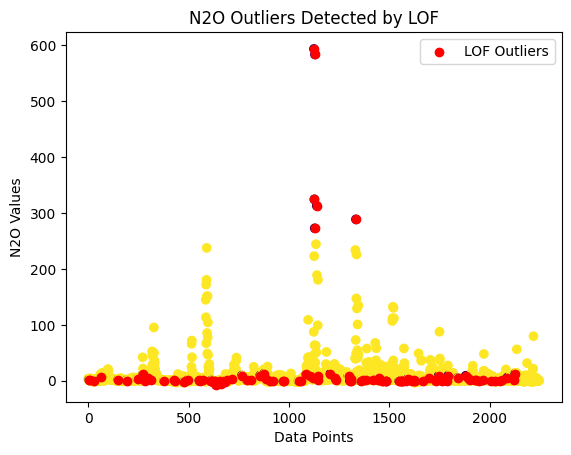

LOF Outlier Table:
            Date  Year Experiment   DataUse Replication     Month Vegetation  \
5        3/17/12  2012   BCSE_KBS  Building          R1     March       Corn   
9        4/20/12  2012   BCSE_KBS  Building          R1     April       Corn   
27       6/11/12  2012   BCSE_KBS  Building          R1      June       Corn   
63       7/21/12  2012   BCSE_KBS  Building          R1      July       Corn   
150     10/17/12  2012   BCSE_KBS  Building          R1   October       Corn   
...          ...   ...        ...       ...         ...       ...        ...   
2051  11/13/2007  2007    MCSE-T2   Testing          R1  November      TRIAE   
2061    5/8/2009  2009    MCSE-T2   Testing          R1       May      GLYMX   
2087   8/21/2009  2009    MCSE-T2   Testing          R4    August      GLYMX   
2121   6/10/2010  2010    MCSE-T2   Testing          R3      June      TRIAE   
2126   6/24/2010  2010    MCSE-T2   Testing          R4      June      TRIAE   

     VegType        

In [19]:
# Extract the N2O column
n2o_values = df['N2O']

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
outlier_scores = lof.fit_predict(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from LOF
outliers = df[outlier_scores == -1]

# Visualize LOF outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='LOF Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by LOF')
plt.legend()
plt.show()

# Print the LOF outlier table
print("LOF Outlier Table:")
print(outliers)

In [ ]:
df

In [ ]:
from pyod.models.cblof import CBLOF
# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
outlier_scores = cblof.fit_predict(n2o_values)

# Get the outlier indices from CBLOF
outliers = df[outlier_scores == 1]

# Visualize CBLOF outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='CBLOF Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by CBLOF')
plt.legend()
plt.show()

# Print the CBLOF outlier table
print("CBLOF Outlier Table:")
print(outliers)

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
outlier_scores = robust_cov.fit_predict(n2o_values)

# Get the outlier indices from the Robust Covariance Estimation
outliers = df[outlier_scores == -1]

# Visualize the Robust Covariance Estimation outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by Robust Covariance Estimation')
plt.legend()
plt.show()

# Print the Robust Covariance Estimation outlier table
print("Robust Covariance Estimation Outlier Table:")
print(outliers)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.cblof import CBLOF
from sklearn.covariance import EllipticEnvelope

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_outliers = dbscan.fit_predict(n2o_values)

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics_outliers = optics.fit_predict(n2o_values)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
lof_outliers = lof.fit_predict(n2o_values)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
cblof_outliers = cblof.fit_predict(n2o_values)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
robust_cov_outliers = robust_cov.fit_predict(n2o_values)

# Visualize outlier detection results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.scatter(df.index, n2o_values, c=dbscan_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('DBSCAN Outliers')

plt.subplot(2, 3, 2)
plt.scatter(df.index, n2o_values, c=optics_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('OPTICS Outliers')

plt.subplot(2, 3, 3)
plt.scatter(df.index, n2o_values, c=lof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('LOF Outliers')

plt.subplot(2, 3, 4)
plt.scatter(df.index, n2o_values, c=cblof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('CBLOF Outliers')

plt.subplot(2, 3, 5)
plt.scatter(df.index, n2o_values, c=robust_cov_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Robust Covariance Estimation Outliers')

plt.tight_layout()
plt.show()

# Print the outlier tables
print("DBSCAN Outlier Table:")
print(df[dbscan_outliers == -1])

print("\nOPTICS Outlier Table:")
print(df[optics_outliers == -1])

print("\nLOF Outlier Table:")
print(df[lof_outliers == -1])

print("\nCBLOF Outlier Table:")
print(df[cblof_outliers == -1])

print("\nRobust Covariance Estimation Outlier Table:")
print(df[robust_cov_outliers == -1])

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.cblof import CBLOF
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_outliers = dbscan.fit_predict(n2o_values)

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics_outliers = optics.fit_predict(n2o_values)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
lof_outliers = lof.fit_predict(n2o_values)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
cblof_outliers = cblof.fit_predict(n2o_values)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
robust_cov_outliers = robust_cov.fit_predict(n2o_values)

# Apply Isolation Forest for outlier detection
isolation_forest = IsolationForest(contamination=0.05, random_state=0)
isolation_forest_outliers = isolation_forest.fit_predict(n2o_values)

# Apply One-Class SVM for outlier detection
one_class_svm = OneClassSVM(nu=0.05)
one_class_svm_outliers = one_class_svm.fit_predict(n2o_values)

# Visualize outlier detection results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(df.index, n2o_values, c=dbscan_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('DBSCAN Outliers')

plt.subplot(2, 3, 2)
plt.scatter(df.index, n2o_values, c=optics_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('OPTICS Outliers')

plt.subplot(2, 3, 3)
plt.scatter(df.index, n2o_values, c=lof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('LOF Outliers')

plt.subplot(2, 3, 4)
plt.scatter(df.index, n2o_values, c=cblof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('CBLOF Outliers')

plt.subplot(2, 3, 5)
plt.scatter(df.index, n2o_values, c=robust_cov_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Robust Covariance Estimation Outliers')

plt.subplot(2, 3, 6)
plt.scatter(df.index, n2o_values, c=isolation_forest_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Isolation Forest Outliers')

plt.tight_layout()
plt.show()

# Print the outlier tables
print("DBSCAN Outlier Table:")
print(df[dbscan_outliers == -1])

print("\nOPTICS Outlier Table:")
print(df[optics_outliers == -1])

print("\nLOF Outlier Table:")
print(df[lof_outliers == -1])

print("\nCBLOF Outlier Table:")
print(df[cblof_outliers == -1])

print("\nRobust Covariance Estimation Outlier Table:")
print(df[robust_cov_outliers == -1])

print("\nIsolation Forest Outlier Table:")
print(df[isolation_forest_outliers == -1])

print("\nOneClass SVM Outlier Table:")
print(df[one_class_svm_outliers == -1])

In [ ]:
df

In [ ]:
# Extract the N2O column
n2o_column = data['N2O']

# Create a box plot of the N2O column
plt.boxplot(n2o_column)
plt.xlabel('N2O')
plt.ylabel('Values')
plt.title('Box Plot of N2O')
plt.show()

# Calculate the upper and lower fences
q1 = n2o_column.quantile(0.25)
q3 = n2o_column.quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# Identify potential outliers based on the box plot and maximum/minimum values
outliers = n2o_column[(n2o_column < lower_fence) | (n2o_column > upper_fence) | (n2o_column > n2o_column.max()) | (n2o_column < n2o_column.min())]

print("Potential outliers:")
print(outliers)

In [ ]:

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import DBSCAN


In [ ]:

# Load the data
# data = pd.read_csv('path_to_your_csv_file.csv')
n2o_data = data[['N2O']]

# Initialize the outlier detection models
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
lof = LocalOutlierFactor(contamination=0.1)
one_class_svm = OneClassSVM(nu=0.1)
elliptic_envelope = EllipticEnvelope(contamination=0.1)
hbos = HBOS()
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the models and predict outliers
n2o_data['IF_Outlier'] = isolation_forest.fit_predict(n2o_data)
n2o_data['LOF_Outlier'] = lof.fit_predict(n2o_data)
n2o_data['OCSVM_Outlier'] = one_class_svm.fit_predict(n2o_data)
n2o_data['Elliptic_Outlier'] = elliptic_envelope.fit_predict(n2o_data)
n2o_data['HBOS_Outlier'] = hbos.fit_predict(n2o_data)
n2o_data['DBSCAN_Outlier'] = dbscan.fit_predict(n2o_data)

# Calculate Mahalanobis Distance and detect outliers
cov_matrix = n2o_data[['N2O']].cov().to_numpy()
mean_distr = n2o_data[['N2O']].mean().to_numpy()
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, mean, inv_cov_matrix):
    return mahalanobis(x, mean, inv_cov_matrix)

n2o_data['Mahalanobis_Distance'] = n2o_data[['N2O']].apply(lambda x: mahalanobis_distance(x, mean_distr, inv_cov_matrix), axis=1)
threshold = n2o_data['Mahalanobis_Distance'].quantile(0.95)
n2o_data['Mahalanobis_Outlier'] = (n2o_data['Mahalanobis_Distance'] > threshold).astype(int)

# Save the results to a CSV file
n2o_data.to_csv('n2o_outlier_detection_results.csv', index=False)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot the original data with outliers highlighted
plt.scatter(n2o_data.index, n2o_data['N2O'], color='blue', label='Data')
plt.scatter(n2o_data.index[n2o_data['IF_Outlier'] == -1], n2o_data['N2O'][n2o_data['IF_Outlier'] == -1], color='red', label='Isolation Forest Outliers')
plt.scatter(n2o_data.index[n2o_data['LOF_Outlier'] == -1], n2o_data['N2O'][n2o_data['LOF_Outlier'] == -1], color='green', label='LOF Outliers')
plt.scatter(n2o_data.index[n2o_data['OCSVM_Outlier'] == -1], n2o_data['N2O'][n2o_data['OCSVM_Outlier'] == -1], color='orange', label='One-Class SVM Outliers')
plt.scatter(n2o_data.index[n2o_data['Elliptic_Outlier'] == -1], n2o_data['N2O'][n2o_data['Elliptic_Outlier'] == -1], color='purple', label='Elliptic Envelope Outliers')
plt.scatter(n2o_data.index[n2o_data['HBOS_Outlier'] == -1], n2o_data['N2O'][n2o_data['HBOS_Outlier'] == -1], color='brown', label='HBOS Outliers')
plt.scatter(n2o_data.index[n2o_data['DBSCAN_Outlier'] == -1], n2o_data['N2O'][n2o_data['DBSCAN_Outlier'] == -1], color='pink', label='DBSCAN Outliers')
plt.scatter(n2o_data.index[n2o_data['Mahalanobis_Outlier'] == 1], n2o_data['N2O'][n2o_data['Mahalanobis_Outlier'] == 1], color='black', label='Mahalanobis Outliers')

# Adding labels and title
plt.title('N2O Outlier Detection Results')
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.legend()
plt.show()

In [ ]:
file_path = 'dataset/agriculture_dataset.csv'
data = pd.read_csv(file_path)

In [ ]:
data

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the data
# file_path = 'path_to_your_csv_file.csv'
# data = pd.read_csv(file_path)
X = data[['N2O']]

# Initialize the outlier detection models
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
lof = LocalOutlierFactor(contamination=0.1, novelty=True)
one_class_svm = OneClassSVM(nu=0.1)
elliptic_envelope = EllipticEnvelope(contamination=0.1)
hbos = HBOS()
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the models and predict outliers
data['if_outlier'] = isolation_forest.fit_predict(X)
lof.fit(X)
data['lof_outlier'] = lof.predict(X)
data['ocsvm_outlier'] = one_class_svm.fit_predict(X)
data['elliptic_outlier'] = elliptic_envelope.fit_predict(X)
data['hbos_outlier'] = hbos.fit_predict(X)
data['dbscan_outlier'] = dbscan.fit_predict(X)

# Calculate Mahalanobis Distance and detect outliers
cov_matrix = X.cov().to_numpy()
mean_distr = X.mean().to_numpy()
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, mean, inv_cov_matrix):
    return mahalanobis(x, mean, inv_cov_matrix)

data['mahalanobis_distance'] = X.apply(lambda x: mahalanobis_distance(x, mean_distr, inv_cov_matrix), axis=1)
threshold = data['mahalanobis_distance'].quantile(0.95)
data['mahalanobis_outlier'] = (data['mahalanobis_distance'] > threshold).astype(int)

# Generate synthetic ground truth labels for evaluation purposes
# Creating a synthetic ground truth based on majority voting of outliers
data['majority_voting'] = data.apply(lambda row: 1 if row[['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']].mode()[0] == 1 else -1, axis=1)

# Append the outlier results to the original data
# data = pd.concat([data, data[['IF_outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'mahalanobis_Outlier', 'Majority_Voting']]], axis=1)

# Save the updated data to the CSV file
data.to_csv('dataset/09_05_1_AgricultureOutliersResult_30052024.csv', index=False)

In [ ]:
data

In [ ]:

# Generate synthetic ground truth labels for evaluation purposes
# Here, we'll assume that '1' indicates inliers and '-1' indicates outliers in the original data
# This is just for the sake of comparison; in a real scenario, ground truth labels would be known
# Creating a synthetic ground truth based on majority voting of outliers
# data['majority_voting'] = data.apply(lambda row: 1 if row[['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']].mode()[0] == 1 else -1, axis=1)

# Calculate precision, recall, and F1-score for each method
evaluation_metrics = {}

# methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']
methods = ['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']

for method in methods:
    precision = precision_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    recall = recall_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    f1 = f1_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    evaluation_metrics[method] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}


# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_05_2_n2o_outlier_detection_evaluation.csv', index=True)

# Display the evaluation results
evaluation_df

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

# Generate synthetic ground truth labels for evaluation purposes
data['Majority_Voting'] = data.apply(lambda row: 1 if row[['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']].mode()[0] == 1 else -1, axis=1)

# Convert outlier labels to binary (1 for outliers, 0 for inliers) for evaluation metrics
y_true = (data['Majority_Voting'] == -1).astype(int)

# Calculate evaluation metrics for each method
evaluation_metrics = {}

methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']

for method in methods:
    y_pred = (data[method] == -1).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    ade = np.mean(np.abs(y_true - y_pred))

    evaluation_metrics[method] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': ap,
        'AUC-ROC': auc_roc,
        'ADE': ade
    }

# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_05_3_AgricultureOutliersEvaluationMatrix_30052024.csv', index=True)

# Save the updated data with outlier detection results
data.to_csv('dataset/09_05_3_AgricultureOutliersResultMatrix_30052024.csv', index=False)

# Display the evaluation results
print(evaluation_df)

# Display the updated dataframe with outlier detection results
print(data.head())

In [ ]:
# Visualization
evaluation_df.plot(kind='bar', figsize=(15, 10))
plt.title('Evaluation Metrics for Outlier Detection Methods')
plt.ylabel('Score')
plt.xlabel('Outlier Detection Methods')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Visualization of comparison of metrics across methods
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Comparison of Evaluation Metrics Across Outlier Detection Methods')

# Precision
evaluation_df[['Precision']].plot(kind='bar', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Score')

# Recall
evaluation_df[['Recall']].plot(kind='bar', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Score')

# F1-Score
evaluation_df[['F1-Score']].plot(kind='bar', ax=axes[1, 0], legend=False)
axes[1, 0].set_title('F1-Score')
axes[1, 0].set_ylabel('Score')

# Average Precision
evaluation_df[['Average Precision']].plot(kind='bar', ax=axes[1, 1], legend=False)
axes[1, 1].set_title('Average Precision')
axes[1, 1].set_ylabel('Score')

# AUC-ROC
evaluation_df[['AUC-ROC']].plot(kind='bar', ax=axes[2, 0], legend=False)
axes[2, 0].set_title('AUC-ROC')
axes[2, 0].set_ylabel('Score')

# ADE
evaluation_df[['ADE']].plot(kind='bar', ax=axes[2, 1], legend=False)
axes[2, 1].set_title('ADE')
axes[2, 1].set_ylabel('Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
data

In [ ]:
# Calculate evaluation metrics for each method and ROC curves
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc


evaluation_metrics = {}
roc_curves = {}

methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']

for method in methods:
    y_pred = (data[method] == -1).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    ade = np.mean(np.abs(y_true - y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_curves[method] = (fpr, tpr, roc_auc)

    evaluation_metrics[method] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': ap,
        'AUC-ROC': auc_roc,
        'ADE': ade
    }

# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_03_04_AgricultureOutliersEvaluation.csv', index=True)

# Save the updated data with outlier detection results
data.to_csv('dataset/09_03_4_AgricultureOutliersResult.csv', index=False)

# Display the evaluation results
print(evaluation_df)

# Visualization of AUC-ROC curves
plt.figure(figsize=(10, 8))

for method, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()